In [1]:
import numpy as np
from scipy.constants import c
from tqdm.notebook import tqdm
import h5py as hp
import matplotlib.pyplot as plt
from aps_figures.aps_one_column import *
from FITX import fit_risetime
from mbtrack2 import Synchrotron, Electron
from mbtrack2.utilities import Optics
from mbtrack2.tracking import LongitudinalMap, SynchrotronRadiation, TransverseMap
from mbtrack2.tracking import Beam, Bunch, WakePotential
from mbtrack2.tracking import RFCavity, SynchrotronRadiation
from mbtrack2.tracking.monitors import BunchMonitor, WakePotentialMonitor
from machine_data.TDR2 import *

In [2]:
from SOLEILII_parameters.SOLEILII_TDR_parameters import *
h = H_RF # Harmonic number of the accelerator.
L = CIRCUMFERENCE # Ring circumference in [m].
E0 = ENERGY   # Nominal (total) energy of the ring in [eV].
particle = Electron() # Particle considered.
ac = ALPHA_0  # Momentum compaction factor.
U0 = U_LOSS   # Energy loss per turn in [eV].
tau = np.array([TAU_X, TAU_Y, TAU_Z]) # Horizontal, vertical and longitudinal damping times in [s].
tune = np.array([Q_X, Q_Y]) # Horizontal and vertical tunes.
emit = np.array([EPSILON_X, EPSILON_Y]) # Horizontal and vertical equilibrium emittance in [m.rad].
sigma_0 = SIGMA_Z/c # Natural bunch length in [s].
sigma_delta = SIGMA_DP # Equilibrium energy spread.
chro = [1.6, 1.6] # Horizontal and vertical (non-normalized) chromaticities.
turns=25000

In [3]:
from machine_data.soleil import v2366
ring2 = v2366(IDs='close', load_lattice=False)
optics = ring2.optics
print(Q_X, Q_Y)
print(ring2.tune)

54.2 18.3
[54.2 18.3]


In [4]:
ring = Synchrotron(h=ring2.h, optics=optics, particle=particle, L=ring2.L, E0=ring2.E0, ac=ring2.ac, 
                   U0=ring2.U0, tau=ring2.tau, emit=ring2.emit, tune=ring2.tune, 
                   sigma_delta=ring2.sigma_delta, sigma_0=ring2.sigma_0, chro=chro)

In [5]:
mybunch = Bunch(ring,  mp_number=1e5, current=2e-3, alive=True)
np.random.seed(42)
mybunch.init_gaussian()
bunch_monitor = BunchMonitor(0, save_every=1, buffer_size=10, total_size=turns, file_name='bunch_monitor', mpi_mode=False)

In [7]:
long_map = LongitudinalMap(ring)
print('RF cavity voltage phase {:.2f}'.format(np.arccos(ring.U0/V_RF)))
rf = RFCavity(ring, m=1, Vc=V_RF, theta=np.arccos(ring.U0/V_RF))
sr = SynchrotronRadiation(ring, switch=[1, 0, 0])
trans_map = TransverseMap(ring)
wakemodel = load_TDR2_wf(version='TDR2.1_IDopen')
wakemodel.drop(['Wlong', 'Zlong', 'Zxdip', 'Zydip', 'Wxdip'])
wakefield = WakePotential(ring, wakemodel, n_bin=65)
wakepotential_monitor = WakePotentialMonitor(bunch_number=0, wake_types='Wydip', n_bin=65, save_every=1, 
                 buffer_size=500, total_size=turns, file_name=None, mpi_mode=False)
# positions = np.linspace(0, ring.L, 10)
# trans_sector = TransverseMapSector(ring, 
#                                    alpha_initial=np.array((ALPHA_X_SMOOTH, ALPHA_Y_SMOOTH)),
#                                    alpha_final=np.array((ALPHA_X_SMOOTH, ALPHA_Y_SMOOTH)),
#                                    beta_initial=np.array((BETA_X_SMOOTH,BETA_Y_SMOOTH)),
#                                    beta_final=np.array((BETA_X_SMOOTH,BETA_Y_SMOOTH)),
#                                    dispersion_initial=np.array((0, 0, 0, 0)),
#                                    dispersion_final=np.array((0, 0, 0, 0)),
#                                    phase_diff=np.array((2*pi*Q_X/10, 2*pi*Q_Y/10)),
#                                    chro_diff=np.array((0, 0)),
#                                    adts=None)
# trans_map_sectors = []
# for i in range(0, 10):
#     trans_map_sectors.append(trans_sector)
# trans_map_sectors = transverse_map_sector_generator(ring, positions)
for i in tqdm(range(turns)):
    trans_map.track(mybunch)
    long_map.track(mybunch)
    rf.track(mybunch)
    wakefield.track(mybunch)
    wakepotential_monitor.track(mybunch, wakefield)
    # sr.track(mybunch)
    bunch_monitor.track(mybunch)

RF cavity voltage phase 1.32


  0%|          | 0/25000 [00:00<?, ?it/s]

KeyboardInterrupt: 

/home/gubaidulin/Codes/TrackingCodes/mbtrack2/mbtrack2/utilities/misc.py:290: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = impedance.data.append(negative_data)


(-1.0, 1.0)

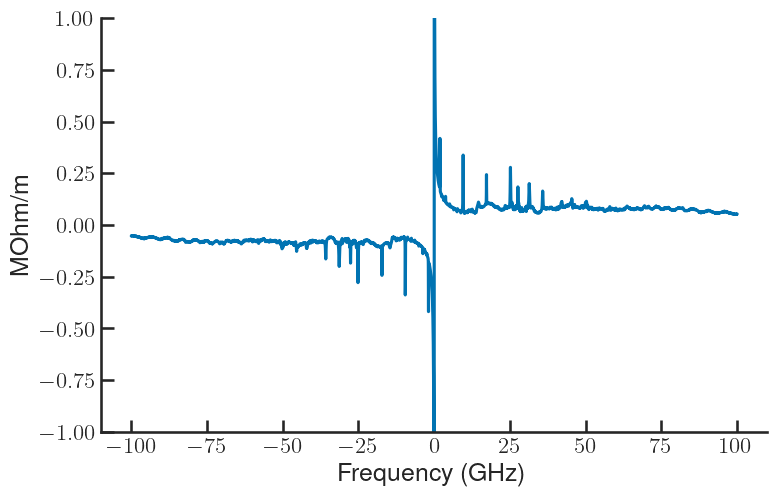

In [12]:
%matplotlib inline
from mbtrack2.utilities.misc import effective_impedance, head_tail_form_factor, spectral_density, double_sided_impedance
from tqdm.notebook import tqdm
Q_s = 1.95e-3
Zydip_obj = load_TDR2_wf(version='TDR2.1_IDopen').Zydip
Zydip_close = load_TDR2_wf(version='TDR2.1_IDclose').Zydip

double_sided_impedance(Zydip_obj)

plt.plot(Zydip_obj.data.index/1e9, Zydip_obj.data['real']/1e6, color='b')
# plt.plot(Zydip_obj.data.index/1e9, Zydip_obj.data['imag']/1e6, color='b')
# plt.plot(Zydip_close.data.index/1e9, Zydip_close.data['real']/1e6, color='r')

plt.xlabel('Frequency (GHz)')
plt.ylabel('MOhm/m')
plt.ylim(-1, 1)

Text(0, 0.5, 'Spectral densiry, $h_{mk}$ (arb.\\,units)')

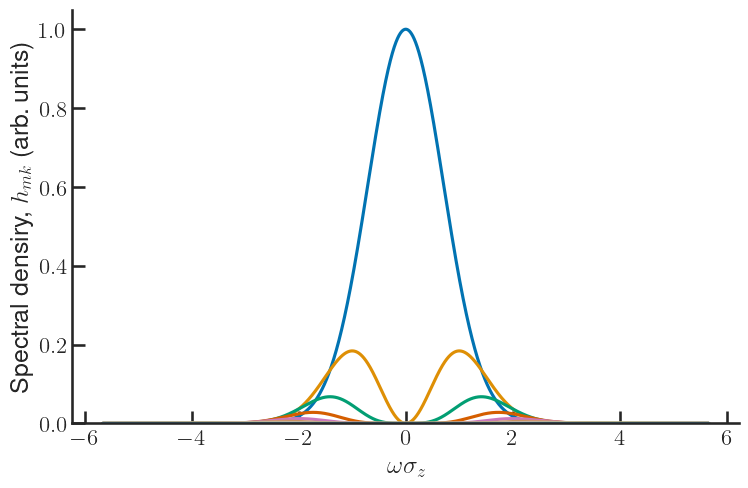

In [8]:
xi = 0
freqs = np.linspace(-Zydip_obj.data.index.max(), Zydip_obj.data.index.max(), 100000) 
f_xi = xi/ring.eta*ring.f0
for m in range(0, 10):
    h = spectral_density(frequency=freqs-f_xi, sigma=mybunch.std[4], m = m, k=0, mode="Hermite")
    plt.plot(freqs*2*np.pi*mybunch.std[4], h, label="$|l|={:}$".format(m))
plt.ylim(0,)
plt.xlabel('$\omega\sigma_z$')
plt.ylabel('Spectral densiry, $h_{mk}$ (arb.\,units)')

-0.16170293750443754

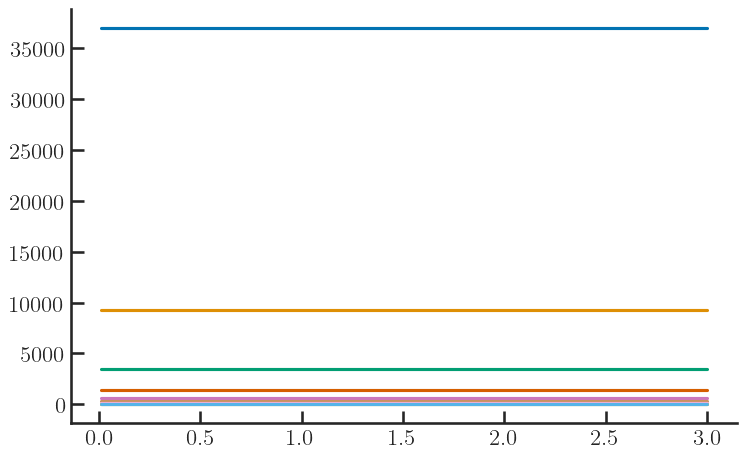

In [9]:
chrom_range = np.linspace(0.01, 3, 100)
from scipy.special import spherical_jn
mode_range = range(0, 10)
chi = np.empty(shape=(chrom_range.shape[0], len(mode_range)))
for i, chrom in enumerate(chrom_range):
    for mode in mode_range:
        chi[i, mode] = (head_tail_form_factor(ring=ring, imp=Zydip_obj, tuneS=Q_s, m=mode, sigma=mybunch.std[4], xi=chrom, mode="Hermite"))
for mode in mode_range:
    plt.plot(chrom_range, chi[:,mode])
       
fmin = Zydip_obj.data.index.min()
fmax = Zydip_obj.data.index.max()
(spherical_jn(1,  np.abs(2*np.pi*fmin*mybunch.std[4])))

In [10]:
Z_eff  = np.empty(shape=(chrom_range.shape[0], len(mode_range)), dtype=np.complex_)
for i, chrom in enumerate(tqdm(chrom_range)):
    for mode in mode_range:
        Z_eff[i, mode] = effective_impedance(ring=ring, imp=Zydip_obj, m=mode, mu=0, sigma=mybunch.std[4], M=1, tuneS=Q_s, xi=chrom, mode="Hermite")


  0%|          | 0/100 [00:00<?, ?it/s]

Single bunch intensity 8.9e+09
Ring energy 2.75e+09


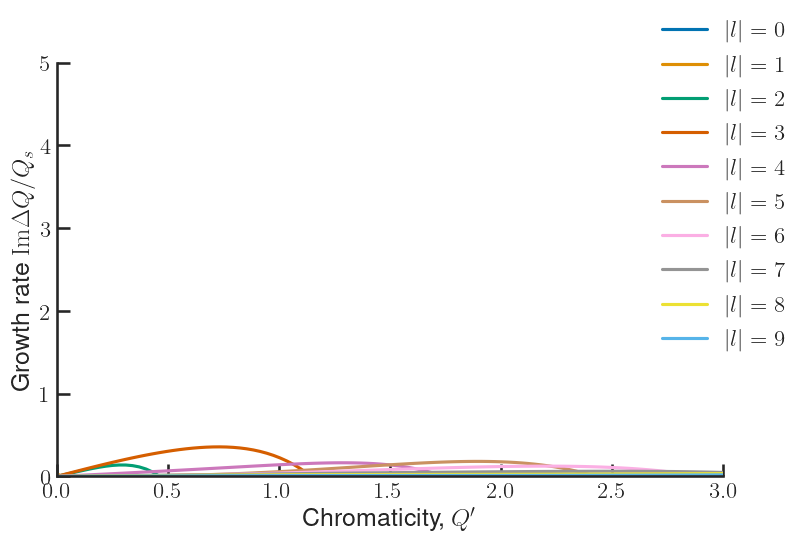

In [11]:
%matplotlib inline
from scipy.constants import e, c, pi
palette = sbs.color_palette('colorblind', 11)
M=416
I_b = 500e-3/H_RF
N_b = I_b/ring.f0/e
print('Single bunch intensity {:.1e}'.format(N_b))
print('Ring energy {:.2e}'.format(ring.E0))
coeff = e*2*pi**2*M*N_b*ring.f0/ring.E0/(2*pi)
for mode in mode_range:
    plt.plot(chrom_range, -coeff*np.real(Z_eff[:,mode])*chi[:,mode]/Q_S, color=palette[mode], label='$|l|={:}$'.format(mode))
    # plt.plot(chrom_range, np.real(Z_eff[:,mode]), color=palette[mode])
    # plt.plot(chrom_range, np.imag(Z_eff[:,mode]), color=palette[mode], linestyle='dashed')
    
plt.xlim(0, 3)
plt.ylim(0, 5)
# plt.axvline(1.6)
plt.xlabel("Chromaticity, $Q'$")
plt.ylabel("Growth rate $\mathrm{Im}{\Delta Q}/Q_s$")
plt.figlegend()

In [53]:
fmax = np.max(freqs)
fmin = np.min(freqs)
M=1
pmax = fmax/(ring.f0 * M) - 1
pmin = fmin/(ring.f0 * M) + 1
prange = np.arange(pmin, pmax)
print(len(prange))

235988


In [54]:
Zydip_obj = load_TDR2_wf(version='TDR2.1_IDopen').Zydip
print(len(Zydip_obj.data.index))

500000
